 # First raw analysis

In [3]:
%run 30_testing_different_bandwidths_sf.ipynb

data_folder = ..\Psychopy_data\exp\B_theta_B_sf


Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier tmp existe d‚j….
Une erreur s'est produite lors du traitement deÿ: tmp.


Overwriting tmp/30_testing_different_bandwidths.py


Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier ..\Psychopy_data\exp\B_theta_B_sf existe d‚j….
Une erreur s'est produite lors du traitement deÿ: ..\Psychopy_data\exp\B_theta_B_sf.



 Initializing
B_thetas =  [0.09817477 1.11072073]
B_sfs =  [0.0625 0.25   1.    ]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
# put the code corresponding to your participants

subj_name_list =  ['JF2','HL','MP','CR','JM']

subj_data_list = []
import json
for subject in subj_name_list :
    x = json.load(open(os.path.join(data_folder, 'Psychophys_discrim_%s.json' % subject), 'rb'))
     #changer et mettre le path du fichier où se trouve les psychophysic data
    subj_data_list.append(x)

In [6]:
B_theta_list = []
for x in subj_data_list[0] :
    B_theta_list.append(x[3]*180/np.pi)
B_theta_list = sorted(set(B_theta_list))

print('B_theta_list=', B_theta_list)
B_sf_list = []
for x in subj_data_list[0] :
    B_sf_list.append(x[4])
B_sf_list = sorted(set(B_sf_list))
print('B_sf_list=', B_sf_list)

B_theta_list= [5.625, 10.316295486052553, 18.920169343208578, 34.69974357167867, 63.63961030678928]
B_sf_list= [0.0625, 0.125, 0.25, 0.5, 1.0]


In [7]:
# % correct answer
data_dict = {}

for num, data in enumerate(subj_data_list) :
    data_dict[num] = {}
    N_data = len(data)
    data_dict[num]['theta'] = np.zeros((1, N_data))
    data_dict[num]['conditions'] = np.zeros((1, N_data)).astype(np.int)
    data_dict[num]['response'] = np.zeros((1, N_data))
    data_dict[num]['correct'] = np.zeros((1, N_data))
    for i, item in enumerate(data):
        data_dict[num]['theta'][0, i] = item[1]*180/np.pi
        data_dict[num]['conditions'][0, i] = item[5]+item[6]*len(B_theta_list)
        data_dict[num]['response'][0, i] = 1 if item[2] == 'right' else 0
        data_dict[num]['correct'][0, i] = (item[1]>0) if item[2] == 'right' else (item[1]<0)     
    correct = data_dict[num]['correct'].mean()
    print(f'Subject {num} has {correct*100:.3f} % correct overall')

Subject 0 has 84.800 % correct overall
Subject 1 has 89.600 % correct overall
Subject 2 has 85.600 % correct overall
Subject 3 has 84.667 % correct overall
Subject 4 has 81.467 % correct overall


In [8]:
data_dict = {}

for num, data in enumerate(subj_data_list) :
    data_dict[num] = {}
    N_data = len(data)
    data_dict[num]['theta'] = np.zeros((1, N_data))
    data_dict[num]['conditions'] = np.zeros((1, N_data)).astype(np.int)
    data_dict[num]['response'] = np.zeros((1, N_data))
    for i, item in enumerate(data):
        #print(i, item)
        data_dict[num]['theta'][0, i] = item[1]*180/np.pi
        data_dict[num]['conditions'][0, i] = item[5]+item[6]*len(B_theta_list)
        data_dict[num]['response'][0, i] = 1 if item[2] == 'right' else 0

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

N_conditions = len(B_sf_list)*len(B_theta_list)
bias = True
logit0_init, theta0_init, log_wt_init = -np.log(1/.10 - 1), 0.0, np.log(4.)

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0_init, theta0_init, log_wt_init, bias=True):
        super(LogisticRegressionModel, self).__init__()
        if bias:
            self.theta0 = torch.nn.Parameter(theta0_init)
        else:
            self.theta0 = theta0_init
        self.logit0 = torch.nn.Parameter(logit0_init)
        self.log_wt = torch.nn.Parameter(log_wt_init)
        self.do_indep = self.logit0.shape.numel() > 1
        
    def forward(self, theta, i_condition):
        if self.do_indep:
            p0 = torch.sigmoid(self.logit0[i_condition.to(int)])
        else:
            p0 = torch.sigmoid(self.logit0)
            
        theta0 = self.theta0[i_condition.to(int)]
        wt = torch.exp(self.log_wt[i_condition.to(int)])
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-theta0)/wt)
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 12 + 1

def fit_data(logistic_model,
    theta, ind_condition, y,
    learning_rate=learning_rate,
    # batch_size=batch_size,  # previous notebook showed that learning_rate had no influence on performance
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.ByteTensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Theta, Ind_condition, labels = Theta.to(device), Ind_condition.to(device), labels.to(device)        
    
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas)
            
    for epoch in range(int(num_epochs)):
        outputs = logistic_model(Theta, Ind_condition)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {loss.item() /len(theta):.5f}")
            losses = []

    logistic_model.eval()
    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.Tensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta, Ind_condition)
    loss = criterion(outputs, labels).item() / len(theta)
    logistic_model.cpu()
    return logistic_model, loss

In [10]:
bias = False
#bias = True
logit0_init = logit0_init * torch.ones(1)
# indep = logit0_init=logit0_init * torch.ones(int(len(data)/len(B_theta_list)/len(B_sf_list)))
results = {}
for num, data in enumerate(subj_data_list) :
    logistic_model = LogisticRegressionModel(logit0_init * torch.ones(1), theta0_init*torch.ones(N_conditions), torch.log(log_wt_init*torch.ones(N_conditions)), bias=bias)
    logistic_model, loss = fit_data(logistic_model, data_dict[num]['theta'], 
                                    data_dict[num]['conditions'], 
                                    data_dict[num]['response'], verbose=True)
    results[num] = logistic_model
    print("Final loss =", loss)

Iteration: 0 - Loss: 307.21936
Iteration: 128 - Loss: 280.08802
Iteration: 256 - Loss: 265.24224
Iteration: 384 - Loss: 252.55015
Iteration: 512 - Loss: 248.08674
Iteration: 640 - Loss: 247.07323
Iteration: 768 - Loss: 246.82830
Iteration: 896 - Loss: 246.76268
Iteration: 1024 - Loss: 246.74303
Iteration: 1152 - Loss: 246.73657
Iteration: 1280 - Loss: 246.73431
Iteration: 1408 - Loss: 246.73348
Iteration: 1536 - Loss: 246.73315
Iteration: 1664 - Loss: 246.73298
Iteration: 1792 - Loss: 246.73289
Iteration: 1920 - Loss: 246.73282
Iteration: 2048 - Loss: 246.73277
Iteration: 2176 - Loss: 246.73273
Iteration: 2304 - Loss: 246.73269
Iteration: 2432 - Loss: 246.73267
Iteration: 2560 - Loss: 246.73264
Iteration: 2688 - Loss: 246.73262
Iteration: 2816 - Loss: 246.73261
Iteration: 2944 - Loss: 246.73260
Iteration: 3072 - Loss: 246.73258
Iteration: 3200 - Loss: 246.73257
Iteration: 3328 - Loss: 246.73256
Iteration: 3456 - Loss: 246.73256
Iteration: 3584 - Loss: 246.73255
Iteration: 3712 - Loss: 

In [11]:
for num in range(2): print(results[num].logit0)

Parameter containing:
tensor([-2.7794], requires_grad=True)
Parameter containing:
tensor([-3.6595], requires_grad=True)


In [12]:
def npa2str(npa):
    """
    format a numpy array into a string
    """
    return ', '.join(list(map('{:.3f}'.format, npa)))

def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.detach().numpy()
    wt_ = torch.exp(logistic_model.log_wt).detach().numpy()
    p0_ = torch.sigmoid(logistic_model.logit0).detach().numpy()
    N_conditions = wt_.shape[0]
    if verbose:
        #for i_condition in range(N_conditions):
        #    print(f'-> i_condition={i_condition}')
        #    if bias:
        #        print(f"theta0 = {theta0_[i_condition]:.3f}")
        #    print(f"slope = {wt_[i_condition]:.3f}")
        if bias:
            print(f"theta0 = {npa2str(theta0_)}")
        print(f"slope = {npa2str(wt_)}")
        print(f"p0 = {npa2str(p0_)}")
    return theta0_, wt_, p0_

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)

--> observer num 0
slope = 2.656, 0.071, 2.811, 0.797, 19.734, 2.914, 1.631, 2.457, 0.837, 23.385, 2.110, 2.457, 2.656, 4.484, 19.803, 1.631, 3.112, 2.517, 0.829, 13.994, 1.631, 3.575, 1.934, 4.601, 9.523
p0 = 0.058
--> observer num 1
slope = 1.424, 0.081, 1.875, 6.336, 37.072, 1.424, 0.810, 2.489, 1.424, 40.814, 1.666, 1.424, 0.810, 3.020, 10.090, 1.424, 0.081, 2.019, 2.514, 11.514, 0.810, 0.081, 1.424, 2.879, 0.079
p0 = 0.025
--> observer num 2
slope = 2.384, 1.443, 2.396, 7.857, 34.340, 0.071, 0.815, 0.071, 7.018, 13.823, 0.080, 2.051, 2.351, 4.441, 17.914, 0.080, 1.886, 2.384, 5.676, 322.893, 1.443, 0.815, 3.091, 4.866, 16.764
p0 = 0.012
--> observer num 3
slope = 1.662, 1.662, 2.269, 6.077, 64.159, 0.071, 3.140, 3.082, 6.413, 20.425, 2.744, 3.706, 2.269, 4.156, 18.307, 1.662, 0.808, 2.580, 5.833, 32.413, 1.662, 0.808, 0.079, 4.144, 7.416
p0 = 0.029
--> observer num 4
slope = 1.440, 5.836, 3.202, 5.880, 370.110, 2.380, 6.724, 5.189, 16.701, 21.105, 1.179, 0.079, 3.828, 10.764, 9.24

--> observer num 0
--> observer num 1
--> observer num 2
--> observer num 3
--> observer num 4


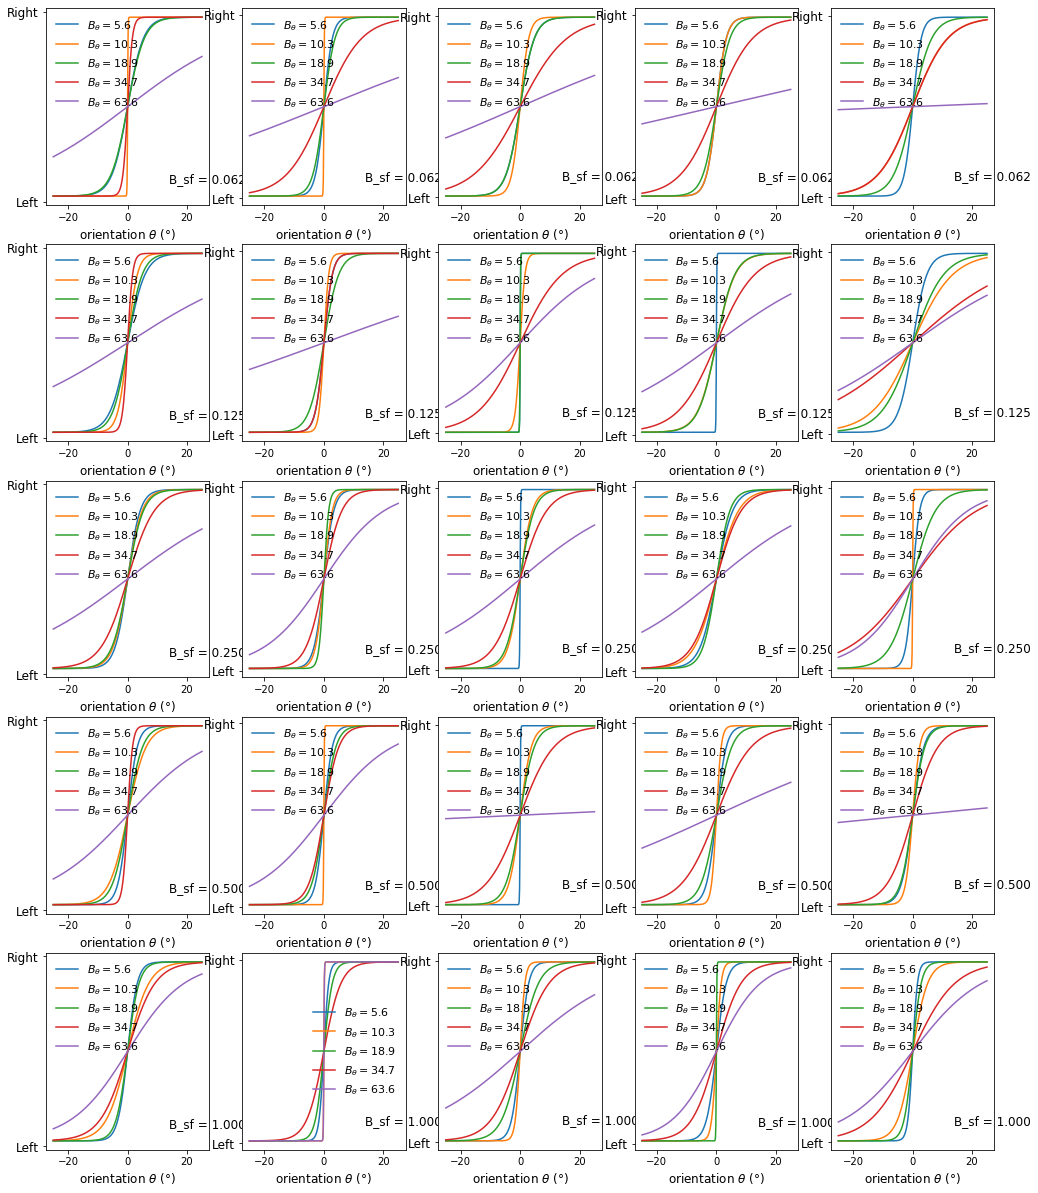

In [13]:
fig, axs = plt.subplots(len(B_sf_list), len(subj_data_list), figsize=(17,21))
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    x_values = np.linspace(-25, 25, 400)

    for i_B_sf, B_sf in enumerate(B_sf_list):
        if len(subj_data_list)>1:
            ax = axs[i_B_sf][num]
        else:
            ax = axs[i_B_sf]

        #colors = plt.cm.inferno(np.linspace(1, .2, len(B_thetas))) #tc colormap

        for i_B_theta, B_theta in enumerate(B_theta_list):
            i_condition = i_B_theta + i_B_sf*len(B_theta_list)
            conditions = i_condition*np.ones_like(x_values)
            y_values = results[num](torch.Tensor(x_values), 
                                      torch.ByteTensor(conditions)).detach().numpy()
            ax.plot(x_values, y_values, label=r'$B_\theta=%s$' % f'{B_theta:.1f}')

        ax.set_xlabel(r"orientation $\theta$ (°)", fontsize=12)
        ax.set_yticks([0.0, 1.0])
        ax.set_yticklabels(["Left", "Right"], fontsize=12)
        ax.legend(fontsize=11, frameon=False, scatterpoints=6)
        if num==0:  ax.legend(fontsize=11, frameon=False, scatterpoints=6)
        ax.text(14, 0.1, f'B_sf = {B_sf:.3f}', fontsize=12)
        

--> observer num 0
slope = 2.656, 0.071, 2.811, 0.797, 19.734, 2.914, 1.631, 2.457, 0.837, 23.385, 2.110, 2.457, 2.656, 4.484, 19.803, 1.631, 3.112, 2.517, 0.829, 13.994, 1.631, 3.575, 1.934, 4.601, 9.523
p0 = 0.058


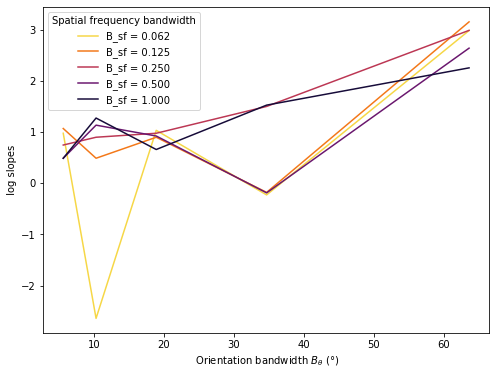

--> observer num 1
slope = 1.424, 0.081, 1.875, 6.336, 37.072, 1.424, 0.810, 2.489, 1.424, 40.814, 1.666, 1.424, 0.810, 3.020, 10.090, 1.424, 0.081, 2.019, 2.514, 11.514, 0.810, 0.081, 1.424, 2.879, 0.079
p0 = 0.025


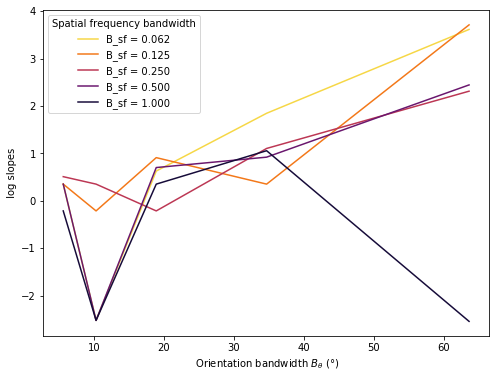

--> observer num 2
slope = 2.384, 1.443, 2.396, 7.857, 34.340, 0.071, 0.815, 0.071, 7.018, 13.823, 0.080, 2.051, 2.351, 4.441, 17.914, 0.080, 1.886, 2.384, 5.676, 322.893, 1.443, 0.815, 3.091, 4.866, 16.764
p0 = 0.012


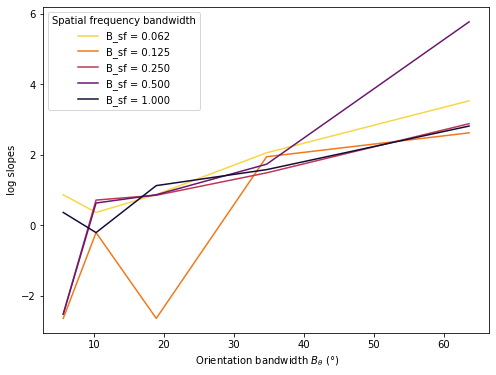

--> observer num 3
slope = 1.662, 1.662, 2.269, 6.077, 64.159, 0.071, 3.140, 3.082, 6.413, 20.425, 2.744, 3.706, 2.269, 4.156, 18.307, 1.662, 0.808, 2.580, 5.833, 32.413, 1.662, 0.808, 0.079, 4.144, 7.416
p0 = 0.029


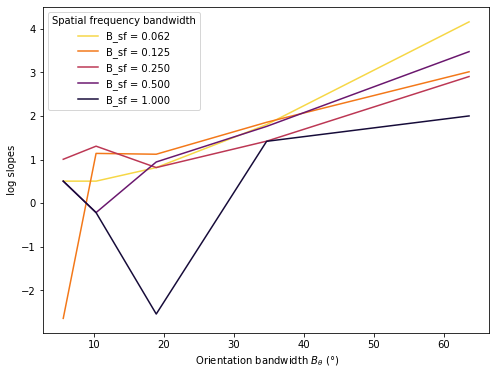

--> observer num 4
slope = 1.440, 5.836, 3.202, 5.880, 370.110, 2.380, 6.724, 5.189, 16.701, 21.105, 1.179, 0.079, 3.828, 10.764, 9.240, 1.884, 1.180, 2.045, 4.258, 153.293, 0.814, 2.531, 1.440, 7.109, 11.682
p0 = 0.015


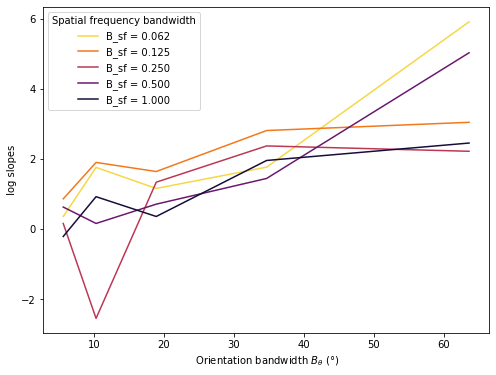

In [14]:
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    colors = plt.cm.inferno(np.linspace(.9, .1, len(B_theta_list)))
    coef_list = []
    plt.figure(figsize = (8,6)) 
    for i_B_sf, B_sf in enumerate(B_sf_list):
        wt__ = wt_[(i_B_sf*len(B_theta_list)):((i_B_sf+1)*len(B_theta_list))]
        plt.plot(B_theta_list, np.log(wt__), label=f'B_sf = {B_sf:.3f}',color=colors[i_B_sf])
    plt.xlabel(r' Orientation bandwidth $B_\theta$ (°)')
    plt.ylabel(r' log slopes ')
    plt.legend(loc ='upper left',title="Spatial frequency bandwidth") 
    plt.show()

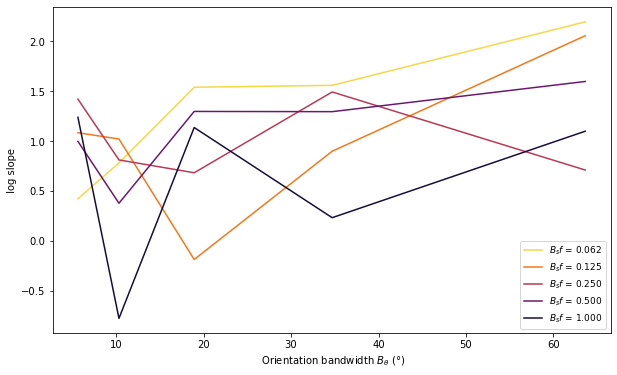

In [20]:
# mean graph of all the performances 

plt.figure(figsize=(10,6))
for i_B_sf, B_sf in enumerate(B_sf_list) :
    Bsf_lst = []
    colors = plt.cm.inferno(np.linspace(.9, .1, len(B_theta_list)))
    for num, data in enumerate(subj_data_list) :
        theta0_, wt_, p0_ = get_params(results[num], verbose=False)
        wt__ = wt_[(i_B_sf*len(B_theta_list)):((i_B_sf+1)*len(B_theta_list))]
        Bsf_lst.append(np.log(wt__))
    
        mean = np.mean(Bsf_lst, axis = 1)
        std = np.std(Bsf_lst, axis = 1)
        
    plt.plot(B_theta_list, mean, label=r'$B_sf$ = %.3f' %B_sf, color=colors[i_B_sf])
    #plt.fill_between(B_theta_list, y1 = mean - std, y2 = mean + std, color = cols[i_sf])
    plt.legend(loc="lower right",fontsize='9')
    #plt.errorbar(B_theta_list, mean, yerr = std, color=colors[i_B_sf])
    plt.xlabel(r' Orientation bandwidth $B_\theta$ (°)')
    plt.ylabel(r' log slope ')